In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import callbacks as cb
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import warnings
warnings.simplefilter('ignore')
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

Using TensorFlow backend.


In [113]:
df = pd.read_excel('data/protva_t_p_q_2003-2015_FOR_LSTM.xlsx', index_col='date')
df.head(14)

,27509t,27509p,27606t,27606p,27611t,27611p,Qt
date,,,,,,,
2003-01-08,0.3,0.7,0.1,0.5,0.0,1.1,8.07
2003-01-09,1.2,0.0,0.6,0.0,1.0,0.0,8.56
2003-01-10,-0.8,0.0,-0.6,0.0,-0.7,0.0,8.23
2003-01-11,-0.2,0.0,-0.5,0.0,-0.4,0.0,8.39
2003-01-12,-2.1,0.0,-2.5,0.0,-2.3,0.0,8.23
2003-01-13,-2.6,0.0,-1.8,0.0,-2.7,0.0,8.39
2003-01-14,-3.3,0.0,-4.0,0.0,-4.1,0.0,8.23
2003-01-15,-4.4,1.7,-4.6,2.1,-4.8,2.0,8.07
2003-01-16,-3.6,0.4,-4.3,0.6,-4.6,0.2,8.23


In [51]:
# define train/test split
test_size = len(df) - 952
# test_size = len(df[df.index.year < 2013])
print('Train: ', test_size)
print('Test: ', len(df) - test_size)
dataset = df.values
data_mean = dataset[:test_size].mean(axis=0)
data_std = dataset[:test_size].std(axis=0)
print(np.round(data_mean, 3), np.round(data_std, 2))
dataset = (dataset-data_mean)/data_std

Train:  3796
Test:  952
[ 5.466  1.955  5.754  1.953  5.5    1.897 23.548] [10.8   4.6  10.75  4.67 10.74  4.39 36.99]


In [69]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

In [89]:
# lookback parameters
past_history = 60 # how many instances a model sees for training, in compliance with other models' input
future_target = 7 # how many instances form a prediction step
STEP = 1 # step size - 1 for daily data
BATCH_SIZE = 30 
BUFFER_SIZE = 1000
EVALUATION_INTERVAL = len(dataset)/BATCH_SIZE # what data model sees for training
EPOCHS = 100 # how many times a model sees the data

# shaping training and test dataset to chunks
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 6], len(dataset) - test_size,
                                                 None, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 6],
                                             0, 952, past_history,
                                             future_target, STEP)
print('\n Input training data shape:')
print(x_train_multi.shape, y_train_multi.shape)
print('\n Input test data shape:')
print(x_val_multi.shape, y_val_multi.shape)
print('\n Single step history:')
print(x_train_multi[0])
print('\n Single step target:')
print(y_train_multi[0])

# create train and test data from chunks
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

# training and test data shuffling
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print(train_data_multi)

952 4748 3796

 Input training data shape:
(3729, 60, 7) (3729, 7)

 Input test data shape:
(892, 60, 7) (892, 7)

 Single step history:
[[ 0.7440816  -0.42463993  0.66455765 -0.41777582  0.75447536 -0.43176976
  -0.35000892]
 [ 0.66999013 -0.42463993  0.71105763 -0.41777582  0.70790084 -0.43176976
  -0.35000892]
 [ 0.81817308 -0.42463993  0.80405758 -0.41777582  0.8383095  -0.43176976
  -0.35541515]
 [ 0.93857173 -0.42463993  0.98075748 -0.41777582  1.01529269 -0.43176976
  -0.35811827]
 [ 1.13306185 -0.22910925  1.1295574  -0.41777582  1.15501626 -0.43176976
  -0.36352451]
 [ 1.04970894 -0.42463993  1.01795746 -0.41777582  1.05255231 -0.43176976
  -0.36352451]
 [ 0.92931029 -0.42463993  0.87845754 -0.41777582  0.88488403 -0.43176976
  -0.36352451]
 [ 0.9570946  -0.42463993  0.84125756 -0.41777582  0.93145855 -0.43176976
  -0.36352451]
 [ 0.97561746 -0.42463993  0.97145749 -0.41777582  1.02460759 -0.43176976
  -0.36082139]
 [ 0.97561746  0.03159832  1.06445744 -0.41777582  1.05255231 

In [90]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(50,
                                          return_sequences=False,
                                          input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(7))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, 
                                                            beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                                            name='Adam'), 
                         loss='mse')

model_callbacks = [cb.EarlyStopping(patience=10), 
                          cb.ModelCheckpoint(filepath=f"results/LSTM_TP.h5", save_best_only=True)]

In [91]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10,
                                          callbacks=model_callbacks)

Epoch 1/100
159/158 [==============================] - 5s 32ms/step - loss: 0.4807 - val_loss: 0.1627
Epoch 2/100
159/158 [==============================] - 5s 30ms/step - loss: 0.3625 - val_loss: 0.1958
Epoch 3/100
159/158 [==============================] - 5s 30ms/step - loss: 0.2884 - val_loss: 0.1594
Epoch 4/100
159/158 [==============================] - 5s 30ms/step - loss: 0.2548 - val_loss: 0.1013
Epoch 5/100
159/158 [==============================] - 5s 30ms/step - loss: 0.1938 - val_loss: 0.1118
Epoch 6/100
159/158 [==============================] - 5s 30ms/step - loss: 0.2264 - val_loss: 0.1023
Epoch 7/100
159/158 [==============================] - 5s 30ms/step - loss: 0.1420 - val_loss: 0.1126
Epoch 8/100
159/158 [==============================] - 5s 30ms/step - loss: 0.1308 - val_loss: 0.1088
Epoch 9/100
159/158 [==============================] - 5s 30ms/step - loss: 0.1145 - val_loss: 0.0885
Epoch 10/100
159/158 [==============================] - 5s 30ms/step - loss: 0.109

In [ ]:
# load trained model for time saving
# multi_step_model = load_model(f"results/LSTM_TP.h5")

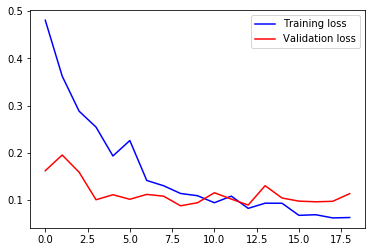

In [92]:
loss = multi_step_history.history['loss']
val_loss = multi_step_history.history['val_loss']
epochs = range(len(loss)) 
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

(3729, 7)
Prediction step : 1
      pred_1  fact_1
0  12.462534    12.8
1  11.532003    13.2
2  10.520612    12.6
3  11.340708    12.0
4  11.280768    11.8
5.971
0.968


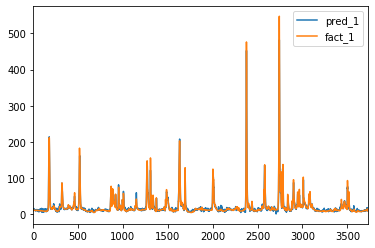

Prediction step : 2
      pred_1  fact_1     pred_2  fact_2
0  12.462534    12.8  13.413610    13.2
1  11.532003    13.2  16.314972    12.6
2  10.520612    12.6  12.604634    12.0
3  11.340708    12.0  10.688471    11.8
4  11.280768    11.8   9.836495    11.8
6.78
0.958


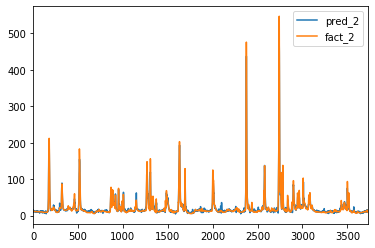

Prediction step : 3
      pred_1  fact_1     pred_2  fact_2     pred_3  fact_3
0  12.462534    12.8  13.413610    13.2  13.494207    12.6
1  11.532003    13.2  16.314972    12.6  16.863487    12.0
2  10.520612    12.6  12.604634    12.0  12.653586    11.8
3  11.340708    12.0  10.688471    11.8  12.003837    11.8
4  11.280768    11.8   9.836495    11.8  11.129473    11.8
7.506
0.949


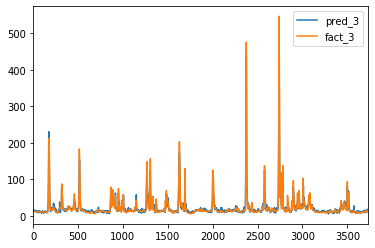

Prediction step : 4
      pred_1  fact_1     pred_2  fact_2     pred_3  fact_3     pred_4  fact_4
0  12.462534    12.8  13.413610    13.2  13.494207    12.6  11.840490    12.0
1  11.532003    13.2  16.314972    12.6  16.863487    12.0  10.870533    11.8
2  10.520612    12.6  12.604634    12.0  12.653586    11.8  11.314952    11.8
3  11.340708    12.0  10.688471    11.8  12.003837    11.8  11.057909    11.8
4  11.280768    11.8   9.836495    11.8  11.129473    11.8  10.426213    11.8
8.59
0.933


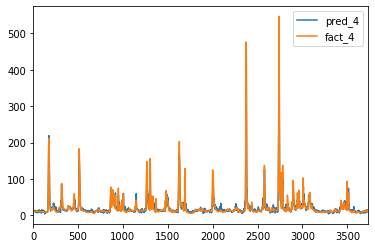

Prediction step : 5
      pred_1  fact_1     pred_2  fact_2     pred_3  fact_3     pred_4  fact_4  \
0  12.462534    12.8  13.413610    13.2  13.494207    12.6  11.840490    12.0   
1  11.532003    13.2  16.314972    12.6  16.863487    12.0  10.870533    11.8   
2  10.520612    12.6  12.604634    12.0  12.653586    11.8  11.314952    11.8   
3  11.340708    12.0  10.688471    11.8  12.003837    11.8  11.057909    11.8   
4  11.280768    11.8   9.836495    11.8  11.129473    11.8  10.426213    11.8   

      pred_5  fact_5  
0  12.405737    11.8  
1  16.568241    11.8  
2  12.038505    11.8  
3  10.938275    11.8  
4  10.331452    11.8  
9.467
0.919


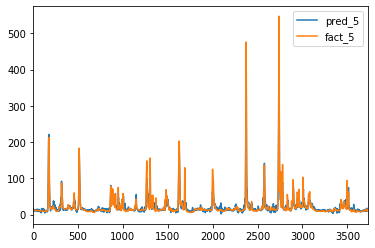

Prediction step : 6
      pred_1  fact_1     pred_2  fact_2     pred_3  fact_3     pred_4  fact_4  \
0  12.462534    12.8  13.413610    13.2  13.494207    12.6  11.840490    12.0   
1  11.532003    13.2  16.314972    12.6  16.863487    12.0  10.870533    11.8   
2  10.520612    12.6  12.604634    12.0  12.653586    11.8  11.314952    11.8   
3  11.340708    12.0  10.688471    11.8  12.003837    11.8  11.057909    11.8   
4  11.280768    11.8   9.836495    11.8  11.129473    11.8  10.426213    11.8   

      pred_5  fact_5     pred_6  fact_6  
0  12.405737    11.8  11.544106    11.8  
1  16.568241    11.8  10.969145    11.8  
2  12.038505    11.8  10.733541    11.8  
3  10.938275    11.8  11.305774    11.8  
4  10.331452    11.8  11.432025    11.8  
10.349
0.903


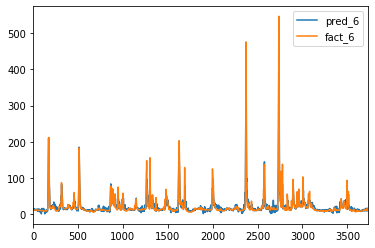

Prediction step : 7
      pred_1  fact_1     pred_2  fact_2     pred_3  fact_3     pred_4  fact_4  \
0  12.462534    12.8  13.413610    13.2  13.494207    12.6  11.840490    12.0   
1  11.532003    13.2  16.314972    12.6  16.863487    12.0  10.870533    11.8   
2  10.520612    12.6  12.604634    12.0  12.653586    11.8  11.314952    11.8   
3  11.340708    12.0  10.688471    11.8  12.003837    11.8  11.057909    11.8   
4  11.280768    11.8   9.836495    11.8  11.129473    11.8  10.426213    11.8   

      pred_5  fact_5     pred_6  fact_6     pred_7  fact_7  
0  12.405737    11.8  11.544106    11.8  11.543810    11.8  
1  16.568241    11.8  10.969145    11.8  13.175250    11.8  
2  12.038505    11.8  10.733541    11.8  12.739959    11.8  
3  10.938275    11.8  11.305774    11.8  13.119332    11.8  
4  10.331452    11.8  11.432025    11.8  12.127888    11.8  
11.877
0.872


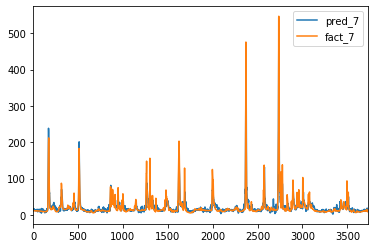

In [94]:
res_df_train = pd.DataFrame()
# compare train data and prediction
print(y_train_multi.shape)
for i in range(y_train_multi.shape[1]):
    print('Prediction step :', i + 1)
    train_df = pd.DataFrame(data={'pred_' + str(i+1): multi_step_model.predict(x_train_multi)[:,i], 'fact_' + str(i+1): y_train_multi[:,i]})
    train_df = train_df * data_std[6] + data_mean[6]
    res_df_train = pd.concat([res_df_train, train_df], sort=False, axis=1)
    print(res_df_train.head())
    print(round(mean_squared_error(train_df['fact_' + str(i+1)], train_df['pred_' + str(i+1)]), 3))
    print(round(r2_score(train_df['fact_' + str(i+1)], train_df['pred_' + str(i+1)]), 3))
    train_df.plot()
    plt.show()
res_df_train.to_excel('results/LSTM_TP_train.xlsx')

Prediction step : 1
               pred_1  fact_1
date                         
2003-03-01   9.648261    7.50
2003-03-02   9.720897    7.33
2003-03-03  11.690913    7.59
2003-03-04  12.548574    7.25
2003-03-05  11.906592    7.67
7.568
0.959


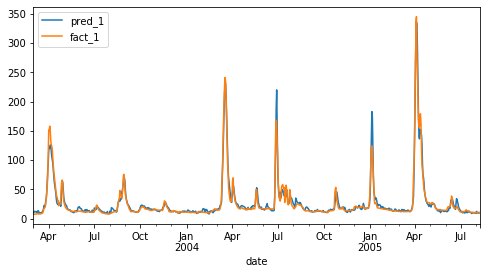

Prediction step : 2
               pred_1  fact_1     pred_2  fact_2
date                                            
2003-03-01   9.648261    7.50   9.983516    7.33
2003-03-02   9.720897    7.33   9.817659    7.59
2003-03-03  11.690913    7.59  10.785016    7.25
2003-03-04  12.548574    7.25  11.515981    7.67
2003-03-05  11.906592    7.67  11.014895    7.59
11.682
0.902


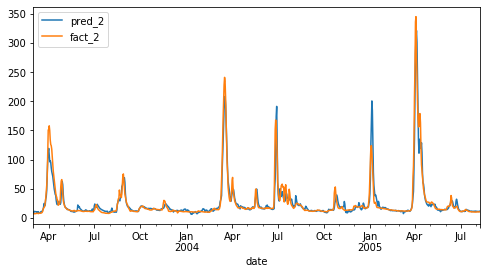

Prediction step : 3
               pred_1  fact_1     pred_2  fact_2    pred_3  fact_3
date                                                              
2003-03-01   9.648261    7.50   9.983516    7.33  6.623156    7.59
2003-03-02   9.720897    7.33   9.817659    7.59  7.231121    7.25
2003-03-03  11.690913    7.59  10.785016    7.25  8.550761    7.67
2003-03-04  12.548574    7.25  11.515981    7.67  9.622069    7.59
2003-03-05  11.906592    7.67  11.014895    7.59  8.894257    7.59
15.163
0.835


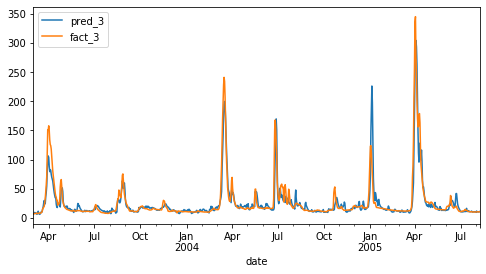

Prediction step : 4
               pred_1  fact_1     pred_2  fact_2    pred_3  fact_3    pred_4  \
date                                                                           
2003-03-01   9.648261    7.50   9.983516    7.33  6.623156    7.59  6.866720   
2003-03-02   9.720897    7.33   9.817659    7.59  7.231121    7.25  6.899492   
2003-03-03  11.690913    7.59  10.785016    7.25  8.550761    7.67  7.951767   
2003-03-04  12.548574    7.25  11.515981    7.67  9.622069    7.59  8.852076   
2003-03-05  11.906592    7.67  11.014895    7.59  8.894257    7.59  8.594338   

            fact_4  
date                
2003-03-01    7.25  
2003-03-02    7.67  
2003-03-03    7.59  
2003-03-04    7.59  
2003-03-05    7.84  
19.859
0.717


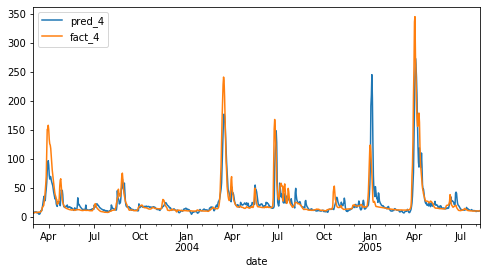

Prediction step : 5
               pred_1  fact_1     pred_2  fact_2    pred_3  fact_3    pred_4  \
date                                                                           
2003-03-01   9.648261    7.50   9.983516    7.33  6.623156    7.59  6.866720   
2003-03-02   9.720897    7.33   9.817659    7.59  7.231121    7.25  6.899492   
2003-03-03  11.690913    7.59  10.785016    7.25  8.550761    7.67  7.951767   
2003-03-04  12.548574    7.25  11.515981    7.67  9.622069    7.59  8.852076   
2003-03-05  11.906592    7.67  11.014895    7.59  8.894257    7.59  8.594338   

            fact_4    pred_5  fact_5  
date                                  
2003-03-01    7.25  6.578878    7.67  
2003-03-02    7.67  6.787510    7.59  
2003-03-03    7.59  8.202402    7.59  
2003-03-04    7.59  9.466597    7.84  
2003-03-05    7.84  9.878264    7.93  
22.884
0.624


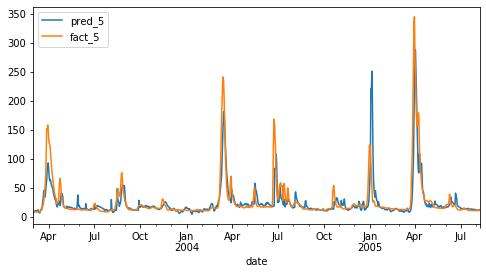

Prediction step : 6
               pred_1  fact_1     pred_2  fact_2    pred_3  fact_3    pred_4  \
date                                                                           
2003-03-01   9.648261    7.50   9.983516    7.33  6.623156    7.59  6.866720   
2003-03-02   9.720897    7.33   9.817659    7.59  7.231121    7.25  6.899492   
2003-03-03  11.690913    7.59  10.785016    7.25  8.550761    7.67  7.951767   
2003-03-04  12.548574    7.25  11.515981    7.67  9.622069    7.59  8.852076   
2003-03-05  11.906592    7.67  11.014895    7.59  8.894257    7.59  8.594338   

            fact_4    pred_5  fact_5     pred_6  fact_6  
date                                                     
2003-03-01    7.25  6.578878    7.67   6.410000    7.59  
2003-03-02    7.67  6.787510    7.59   7.132463    7.59  
2003-03-03    7.59  8.202402    7.59   8.479032    7.84  
2003-03-04    7.59  9.466597    7.84   9.824990    7.93  
2003-03-05    7.84  9.878264    7.93  10.395256    8.37  
25.819
0.521


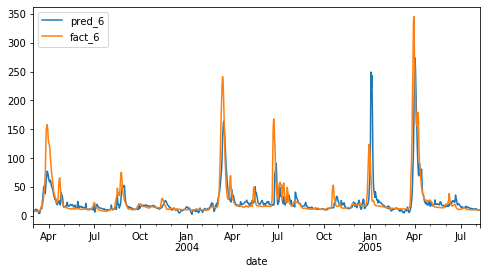

Prediction step : 7
               pred_1  fact_1     pred_2  fact_2    pred_3  fact_3    pred_4  \
date                                                                           
2003-03-01   9.648261    7.50   9.983516    7.33  6.623156    7.59  6.866720   
2003-03-02   9.720897    7.33   9.817659    7.59  7.231121    7.25  6.899492   
2003-03-03  11.690913    7.59  10.785016    7.25  8.550761    7.67  7.951767   
2003-03-04  12.548574    7.25  11.515981    7.67  9.622069    7.59  8.852076   
2003-03-05  11.906592    7.67  11.014895    7.59  8.894257    7.59  8.594338   

            fact_4    pred_5  fact_5     pred_6  fact_6     pred_7  fact_7  
date                                                                        
2003-03-01    7.25  6.578878    7.67   6.410000    7.59   7.275433    7.59  
2003-03-02    7.67  6.787510    7.59   7.132463    7.59   8.110453    7.84  
2003-03-03    7.59  8.202402    7.59   8.479032    7.84  10.384761    7.93  
2003-03-04    7.59  9.466597    7.

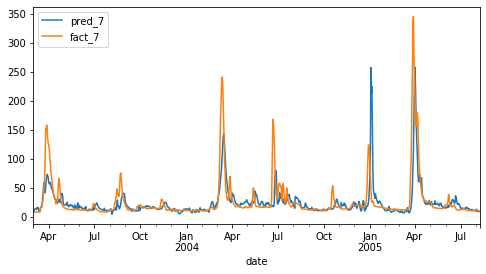

In [125]:
res_df_test = pd.DataFrame()
# compare test data and prediction
for i in range(y_val_multi.shape[1]):
    print('Prediction step :', i + 1)
    val_df = pd.DataFrame(data={'pred_' + str(i+1): multi_step_model.predict(x_val_multi)[:,i], 
                                'fact_' + str(i+1): y_val_multi[:,i]})
    val_df.index = df[past_history-1:(len(df)-test_size-1)].index
    val_df = val_df * data_std[6] + data_mean[6]
    res_df_test = pd.concat([res_df_test, val_df], sort=False, axis=1)
    print(res_df_test.head())
    print(round(RMSE(val_df['fact_' + str(i+1)], val_df['pred_' + str(i+1)]), 3))
    print(round(NSE(val_df['fact_' + str(i+1)], val_df['pred_' + str(i+1)]), 3))
    val_df.plot(figsize=(8,4))
    plt.show()
res_df_test.to_excel('results/LSTM_TP_test.xlsx'.format(river))